In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import seaborn as sns
import os
import re
from statistics import mean, stdev, median
import pandas as pd
sns.set(rc={'text.usetex' : True})

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [14]:
algorithms = ['blind-testWithGenerator', 'mix-testWithGenerator', 'zest-testWithGenerator', 'ei-no-havoc-testWithGenerator']
path = "/data/aoli/results-JQF/paper-data"

cov_path = os.path.join(path, "cov")
mutation_path = os.path.join(path, "mutation")



def violin_plot_for_mutation_distance(df, split=True, inner='quart', density_norm='area', width=0.8, x_order=None):
    plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 'axes.grid': True, 'grid.linestyle': '--'})
    plt.rcParams['figure.figsize'] = 7, 3
    custom_palette = {'Zest-all': '#DD8452', 'Zest-saved': '#BEBADA', 'GEX-all': '#4C72B0'}
    tmp_ax = sns.violinplot(data=df, x='benchmark_name', y='mutation', hue='algorithm',
                            split=split, inner=inner, density_norm=density_norm, palette=custom_palette,
                            width=width, linewidth=1.0, order=x_order, common_norm=True, saturation=1, dodge=True)
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
    for l in tmp_ax.lines:
        l.set_linestyle(':')
        l.set_linewidth(1)
        l.set_color('black')
        l.set_alpha(0.8)
    for l in tmp_ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.6)
        l.set_color('#F7F056')
        l.set_alpha(0.8)

    # get rid of ticks for empty columns (levels)
    if x_order:
        x_arr = np.array(x_order)
        position_arr = np.array(range(0, len(x_order)))
        positions = [p for p, order in zip(position_arr, x_arr) if 'NA' not in order]
        filtered_x = [e for e in list(x_order) if 'NA' not in e]
        tmp_ax.set_xticks(positions)
        tmp_ax.set_xticklabels(filtered_x)
        plt.xticks(rotation=30)

    tmp_ax.set(xlabel='Benchmark', ylabel='Mutation Distance (%)')
    # tmp_ax.grid(False)
    plt.show()

# Mutation Distance Measurement

In [8]:
mutation_df = pd.read_pickle(os.path.join(mutation_path, 'mutation.pkl'))
new_label_names = {'zest-testWithGenerator': 'Zest-all', 'zest-testWithGenerator-saved_only': 'Zest-saved', 'ei-no-havoc-testWithGenerator': 'GEX-all', 'ei-no-havoc-testWithGenerator-saved_only': 'GEX-saved'}
mutation_df['algorithm'] = mutation_df['algorithm'].map(new_label_names)
zest_df = mutation_df[mutation_df['algorithm'].str.contains('Zest')]
all_input_df = mutation_df[mutation_df['algorithm'].str.contains('all')]
non_zero_mutation_df = mutation_df[mutation_df['mutation'] != 0]
non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]

/tmp/ipykernel_2022506/4248415125.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
/tmp/ipykernel_2022506/4248415125.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]


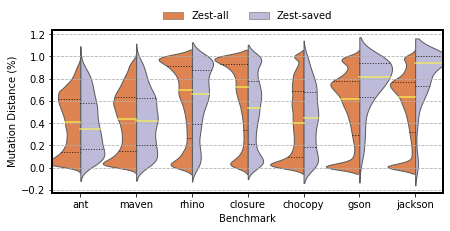

In [6]:
# Figure 7

violin_plot_for_mutation_distance(non_zero_zest_df, width=1.2)

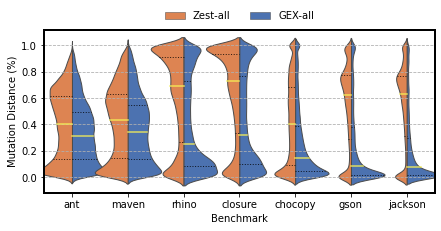

In [7]:
# Figure 8

violin_plot_for_mutation_distance(non_zero_all_input_df, width=1.2)

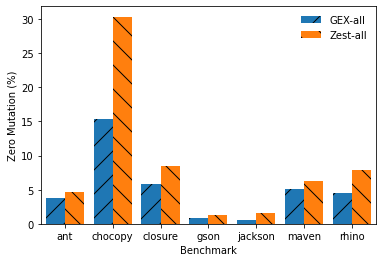

In [10]:
# Figure 12
import matplotlib.patches as mpatches

zero_count = all_input_df.groupby(['algorithm', 'benchmark_name']).apply(lambda x: (x['mutation'] < 0.00000001).sum())
total_count = all_input_df.groupby(['algorithm', 'benchmark_name'])['mutation'].count()
result = pd.DataFrame({'count': zero_count/total_count *100}).reset_index()
ax = sns.barplot(result, x="benchmark_name", y="count", hue="algorithm", saturation=1)

patterns = ['/', '\\']
algo = ["GEX-all", "Zest-all"]
unique_hues = result['algorithm'].unique()
pattern_dict = {hue: patterns[i % len(patterns)] for i, hue in enumerate(unique_hues)}
sorted_patches = sorted(ax.patches, key=lambda patch: patch.get_x())
x = 0
legend_handles = []
for bar in sorted_patches:
    hue_value = algo[x%2]
    bar.set_hatch(pattern_dict[hue_value])
    x += 1

    if hue_value not in [h.get_label() for h in legend_handles]:
        legend_handles.append(mpatches.Patch(facecolor=bar.get_facecolor(),
                                            hatch=pattern_dict[hue_value],
                                            label=hue_value))

plt.legend(handles=legend_handles)
sns.move_legend(ax, "upper right",  title=None, frameon=False)
ax.set(xlabel='Benchmark', ylabel='Zero Mutation (%)')
plt.show()

# Coverage Measurement

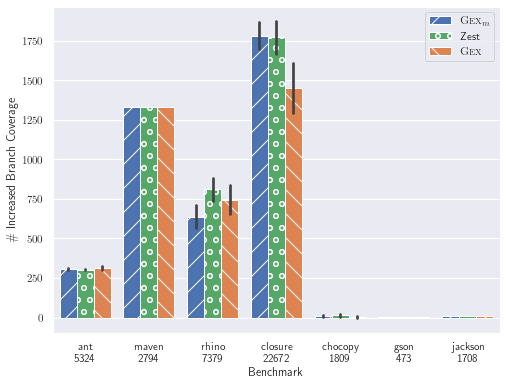

In [16]:
# Figure 9
data_dirs = [
    cov_path
]
from process_data import generate_cov_table
result = generate_cov_table([cov_path], algorithms)